In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def get_Lz_rate(Te, coeffs, limit_values, fit_limits):
            
    logT = np.log(Te)
    log_out = 0

    if Te >= fit_limits[0] and Te <= fit_limits[1]:
        log_out = log_out          \
        +(coeffs[0]) * pow(logT, 0) \
        +(coeffs[1]) * pow(logT, 1) \
        +(coeffs[2]) * pow(logT, 2) \
        +(coeffs[3]) * pow(logT, 3) \
        +(coeffs[4]) * pow(logT, 4) \
        +(coeffs[5]) * pow(logT, 5) \
        +(coeffs[6]) * pow(logT, 6) \
        +(coeffs[7]) * pow(logT, 7) \
        +(coeffs[8]) * pow(logT, 8) \
        +(coeffs[9]) * pow(logT, 9) \
        +(coeffs[10]) * pow(logT, 10) 
        return np.exp(log_out)

    elif Te < fit_limits[0]:
        return limit_values[0]

    else:
        return limit_values[1]
    
Te = np.linspace(0.1, 3000, 50000)
coeffs = [-8.45410692e+01, +1.57727040e+01, -1.54264860e+01, +1.49409902e+01, -1.04815113e+01, +5.00924595e+00, -1.60029106e+00, +3.29455609e-01, -4.14036827e-02, +2.87063206e-03, -8.38888002e-05]
limit_values = [1.95353412e-35, 1.22649600e-32]
fit_limits = [1.5, 1500]

full = pd.DataFrame()
full["Te"] = Te
full["L"] = [get_Lz_rate(x, coeffs, limit_values, fit_limits) for x in Te]


In [46]:
points

,Te,L
8,2.500160,6.056252e-34
65,19.601300,2.175093e-31
416,124.908321,3.412571e-32
9999,3000.000000,1.226496e-32


In [41]:

# L = (L0*(Te1 - Te) + L1*(Te - Te0)) / (Te1 - Te0)

def make_interpolation(p0, p1):
    Te0, Te1 = p0["Te"], p1["Te"]
    L0, L1 = p0["L"], p1["L"]
    
    out = f""" if Te >= {Te0:.2f} and Te < {Te1:.2f}:
        return ({L0:.6e}*({Te1:.2f} - Te) + {L1:.6e}*(Te - {Te0:.2f})) / ({Te1:.2f} - {Te0:.2f})
    """
    
    print(out)

def L_simplified(Te):
    
    if Te < 0.52:
        return 0

    if Te >= 0.52 and Te < 2.50:
        return (1.953534e-35*(2.50 - Te) + 6.053680e-34*(Te - 0.52)) / (2.50 - 0.52)
                    
    if Te >= 2.50 and Te < 19.72:
        return (6.053680e-34*(19.72 - Te) + 2.175237e-31*(Te - 2.50)) / (19.72 - 2.50)
                    
    if Te >= 19.72 and Te < 59.98:
        return (2.175237e-31*(59.98 - Te) + 4.190918e-32*(Te - 19.72)) / (59.98 - 19.72)
                    
    if Te >= 59.98 and Te < 3000.00:
        return (4.190918e-32*(3000.00 - Te) + 1.226496e-32*(Te - 59.98)) / (3000.00 - 59.98)
                    
    if Te > 3000.00:
        return 1.226496e-32
    
def L_simplified2(Te):
    
    if Te < 0.52:
        return 0

    if Te >= 0.52 and Te < 2.50:
        return (1.953534e-35*(2.50 - Te) + 6.053680e-34*(Te - 0.52)) / (2.50 - 0.52)
                    
    if Te >= 2.50 and Te < 19.72:
        return (6.053680e-34*(19.72 - Te) + 2.175237e-31*(Te - 2.50)) / (19.72 - 2.50)
                    
    if Te >= 19.72 and Te < 59.98:
        return (2.175237e-31*(59.98 - Te) + 0.000000e+00*(Te - 19.72)) / (59.98 - 19.72)
                    
    if Te > 59.98:
        return 0.0

def L_simplified3(Te):
    if Te < 0.52:
        return 0

    if Te >= 0.52 and Te < 2.50:
        return (1.953534e-35*(2.50 - Te) + 6.053680e-34*(Te - 0.52)) / (2.50 - 0.52)
                    
    if Te >= 2.50 and Te < 19.72:
        return (6.053680e-34*(19.72 - Te) + 2.175237e-31*(Te - 2.50)) / (19.72 - 2.50)
                    
    if Te >= 19.72 and Te < 38.02:
        return (2.175237e-31*(38.02 - Te) + 0.000000e+00*(Te - 19.72)) / (38.02 - 19.72)
                    
    if Te > 38.02:
        return 0.0



In [44]:
def make_function(points, mode = "python"):

    if mode == "python":
        print(f""" if Te < {points.iloc[0]['Te']:.2f}:
    return 0\n""")
        for i in points.index:
            if i != 0:
                
                p0, p1 = points.iloc[i-1], points.iloc[i]
                Te0, Te1 = p0["Te"], p1["Te"]
                L0, L1 = p0["L"], p1["L"]
                
                print(f""" if Te >= {Te0:.2f} and Te < {Te1:.2f}:
    return ({L0:.6e}*({Te1:.2f} - Te) + {L1:.6e}*(Te - {Te0:.2f})) / ({Te1:.2f} - {Te0:.2f})
                """)
                
        print(f""" if Te > {points.iloc[-1]['Te']:.2f}:
    return {points.iloc[-1]["L"]}\n""")
        
    elif mode == "c++":
        print(fr"""     if (Te < {points.iloc[0]['Te']:.2f}) {{ 
        return 0; 
    """)
        
        for i in points.index:
            if i != 0:
                
                p0, p1 = points.iloc[i-1], points.iloc[i]
                Te0, Te1 = p0["Te"], p1["Te"]
                L0, L1 = p0["L"], p1["L"]
                
                print(f"     }} else if (Te >= {Te0:.2f} and Te < {Te1:.2f}) {{")
                print(f"        return ({L0:.6e}*({Te1:.2f} - Te) + {L1:.6e}*(Te - {Te0:.2f})) / ({Te1:.2f} - {Te0:.2f});\n")
        
        print(f"     }} else {{")
        print(f"        return {points.iloc[-1]['L']};")
        print("     };")
          
        
    else:
        raise ValueError("mode must be python or c++")
            
make_function(simplified3_points, mode = "c++")

     if (Te < 0.52) { 
        return 0; 
    
     } else if (Te >= 0.52 and Te < 2.50) {
        return (1.953534e-35*(2.50 - Te) + 6.053680e-34*(Te - 0.52)) / (2.50 - 0.52);

     } else if (Te >= 2.50 and Te < 19.72) {
        return (6.053680e-34*(19.72 - Te) + 2.175237e-31*(Te - 2.50)) / (19.72 - 2.50);

     } else if (Te >= 19.72 and Te < 38.02) {
        return (2.175237e-31*(38.02 - Te) + 0.000000e+00*(Te - 19.72)) / (38.02 - 19.72);

     } else {
        return 0.0;
     };


## Simplified 1
- Linear interpolation, keep RHS shoulder

In [5]:
%matplotlib inline

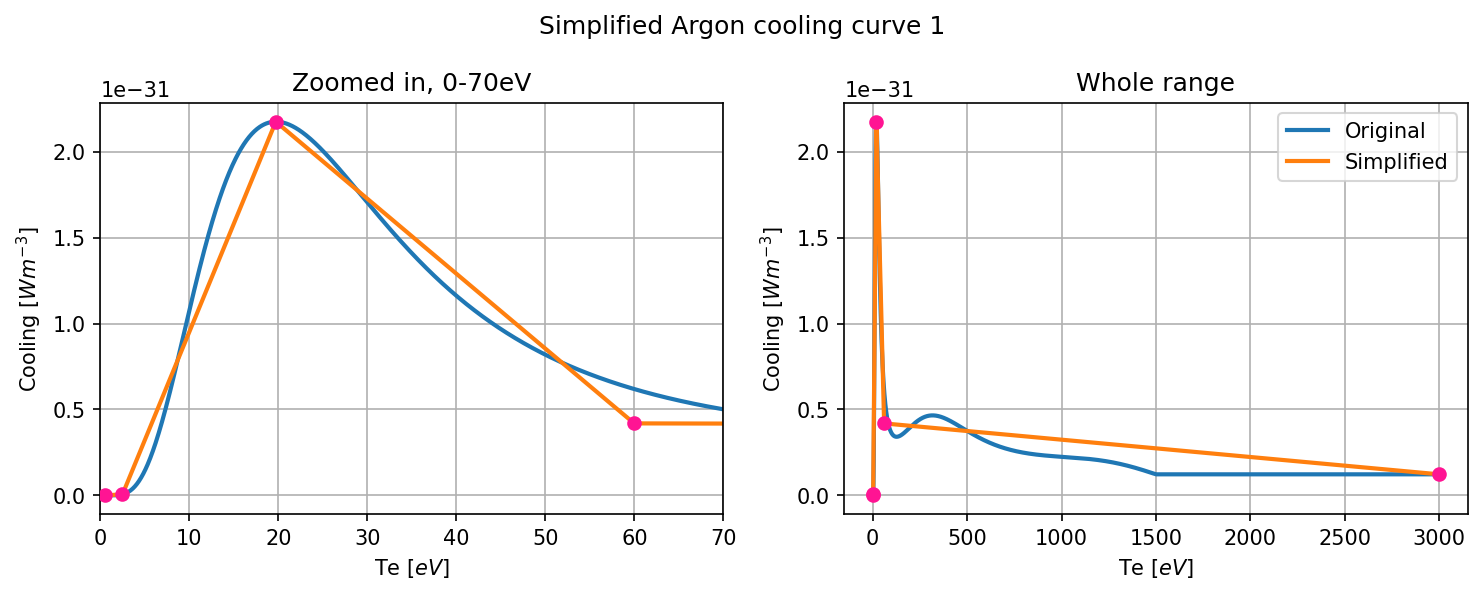

In [22]:
plt.close("all")
fig, axes = plt.subplots(1,2, figsize = (10,4), dpi = 150)

# def argon_simplified(Te):
    
simplified_points = pd.concat([
    full.iloc[(full['Te']-0.5).abs().argsort()[:1]],
    full.iloc[(full['Te']-2.5).abs().argsort()[:1]],
    full[full['L'] == full['L'].max()],
    full.iloc[(full['Te']-60).abs().argsort()[:1]] - 0.2e-31,
    full[full['Te'] == full['Te'].max()],
]).reset_index()

style = dict(lw = 2)

for ax in axes:
    ax.plot(full["Te"], full["L"], **style, label = "Original")
    ax.scatter(simplified_points["Te"], simplified_points["L"], color = "deeppink", zorder = 100)
    ax.plot(full["Te"], [L_simplified(x) for x in full["Te"]], **style, label = "Simplified")
    # ax.set_xscale("log")
    ax.grid()
    ax.set_xlabel("Te $[eV]$")
    ax.set_ylabel("Cooling $[Wm^{-3}]$")
    
axes[0].set_xlim(0,70)
axes[0].set_title("Zoomed in, 0-70eV")
axes[1].set_title("Whole range")
axes[1].legend()
fig.suptitle("Simplified Argon cooling curve 1")
fig.tight_layout()


## Simplified 2
- Linear interpolation and no RHS shoulder

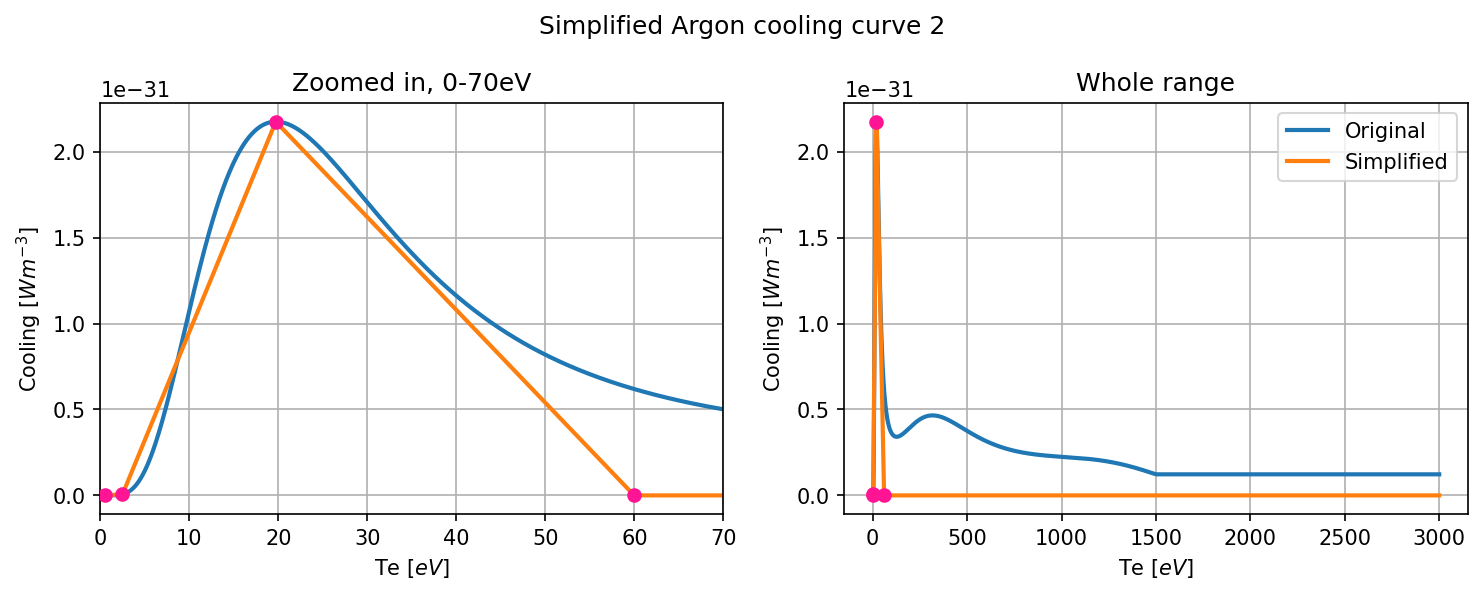

In [37]:
plt.close("all")
fig, axes = plt.subplots(1,2, figsize = (10,4), dpi = 150)

# def argon_simplified(Te):
    
points = pd.concat([
    full.iloc[(full['Te']-0.5).abs().argsort()[:1]],
    full.iloc[(full['Te']-2.5).abs().argsort()[:1]],
    full[full['L'] == full['L'].max()],
    full.iloc[(full['Te']-60).abs().argsort()[:1]] - 0.2e-31,

]).reset_index()
simplified2_points = points.copy()
simplified2_points.loc[3, "L"] = 0


style = dict(lw = 2)

for ax in axes:
    ax.plot(full["Te"], full["L"], **style, label = "Original")
    ax.scatter(simplified2_points["Te"], simplified2_points["L"], color = "deeppink", zorder = 100)
    ax.plot(full["Te"], [L_simplified2(x) for x in full["Te"]], **style, label = "Simplified")
    # ax.set_xscale("log")
    ax.grid()
    ax.set_xlabel("Te $[eV]$")
    ax.set_ylabel("Cooling $[Wm^{-3}]$")
    
axes[0].set_xlim(0,70)
axes[0].set_title("Zoomed in, 0-70eV")
axes[1].set_title("Whole range")
axes[1].legend()
fig.suptitle("Simplified Argon cooling curve 2")
fig.tight_layout()

# Simplified 3

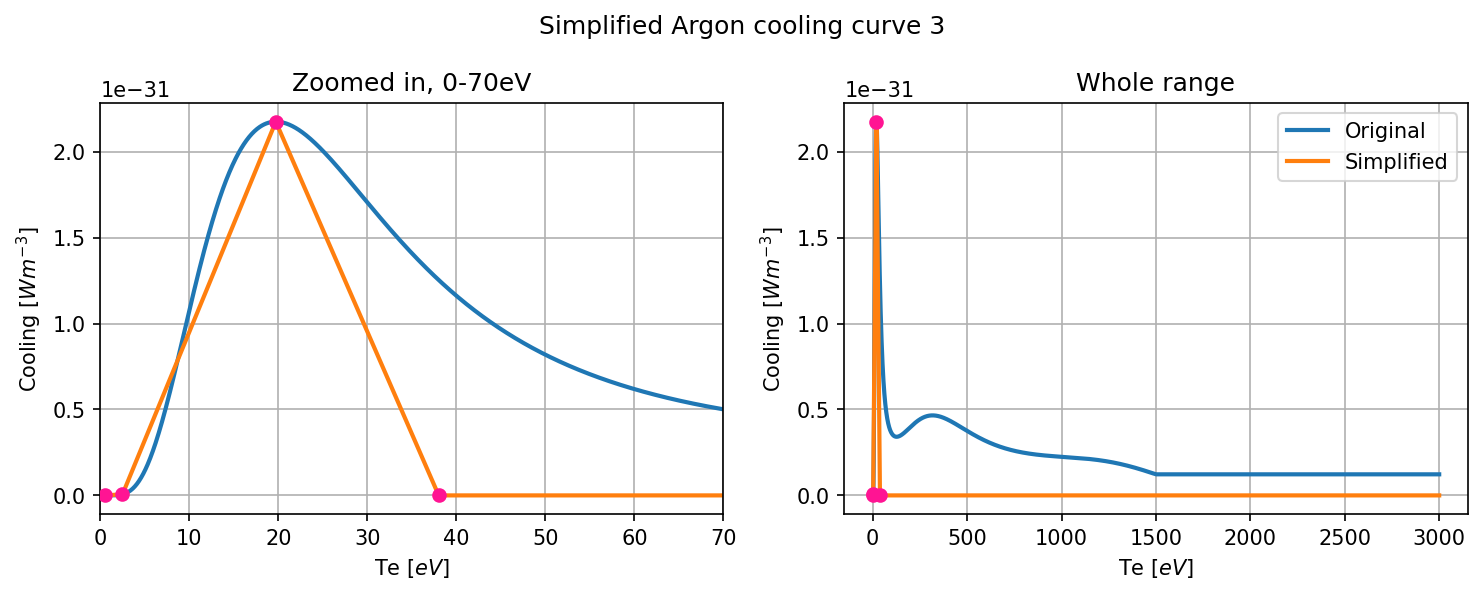

In [43]:
plt.close("all")
fig, axes = plt.subplots(1,2, figsize = (10,4), dpi = 150)

# def argon_simplified(Te):
    
points = pd.concat([
    full.iloc[(full['Te']-0.5).abs().argsort()[:1]],
    full.iloc[(full['Te']-2.5).abs().argsort()[:1]],
    full[full['L'] == full['L'].max()],
    full.iloc[(full['Te']-38).abs().argsort()[:1]] - 0.2e-31,

]).reset_index()
simplified3_points = points.copy()
simplified3_points.loc[3, "L"] = 0


style = dict(lw = 2)

for ax in axes:
    ax.plot(full["Te"], full["L"], **style, label = "Original")
    ax.scatter(simplified3_points["Te"], simplified3_points["L"], color = "deeppink", zorder = 100)
    ax.plot(full["Te"], [L_simplified3(x) for x in full["Te"]], **style, label = "Simplified")
    # ax.set_xscale("log")
    ax.grid()
    ax.set_xlabel("Te $[eV]$")
    ax.set_ylabel("Cooling $[Wm^{-3}]$")
    
axes[0].set_xlim(0,70)
axes[0].set_title("Zoomed in, 0-70eV")
axes[1].set_title("Whole range")
axes[1].legend()
fig.suptitle("Simplified Argon cooling curve 3")
fig.tight_layout()